In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2022-03-26 07:34:55.457715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 07:34:55.508304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 07:34:55.508499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 07:34:55.509047: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [5]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [6]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 2s 3ms/step - loss: 0.6272 - accuracy: 0.6465 - val_loss: 0.4158 - val_accuracy: 0.8278
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.3252 - accuracy: 0.8671 - val_loss: 0.3388 - val_accuracy: 0.8530
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1996 - accuracy: 0.9298 - val_loss: 0.3564 - val_accuracy: 0.8462
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1081 - accuracy: 0.9732 - val_loss: 0.3920 - val_accuracy: 0.8383
Epoch 5/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.9935 - val_loss: 0.4358 - val_accuracy: 0.8343
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0210 - accuracy: 0.9991 - val_loss: 0.4794 - val_accuracy: 0.8330
Epoch 7/10
196/196 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.9997 - val_loss: 0.5157 - val_accuracy: 0.8332
Epoch 

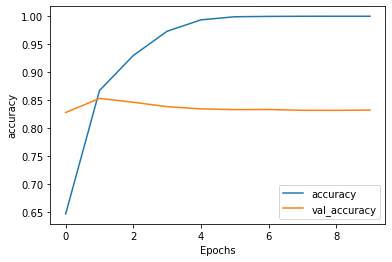

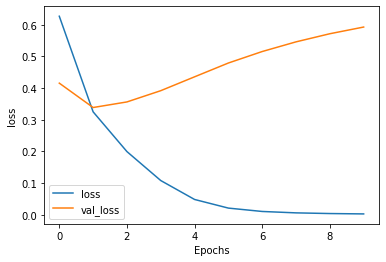

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [9]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-03-26 07:35:47.571900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


196/196 [==============================] - 6s 16ms/step - loss: 0.6869 - accuracy: 0.5800 - val_loss: 0.6440 - val_accuracy: 0.6535
Epoch 2/10
196/196 [==============================] - 3s 14ms/step - loss: 0.6078 - accuracy: 0.6708 - val_loss: 0.5198 - val_accuracy: 0.7390
Epoch 3/10
196/196 [==============================] - 3s 13ms/step - loss: 0.6256 - accuracy: 0.6634 - val_loss: 0.6118 - val_accuracy: 0.6554
Epoch 4/10
196/196 [==============================] - 3s 13ms/step - loss: 0.6307 - accuracy: 0.6018 - val_loss: 0.6157 - val_accuracy: 0.6137
Epoch 5/10
196/196 [==============================] - 2s 12ms/step - loss: 0.5808 - accuracy: 0.6822 - val_loss: 0.5429 - val_accuracy: 0.6864
Epoch 6/10
196/196 [==============================] - 3s 14ms/step - loss: 0.4376 - accuracy: 0.8006 - val_loss: 0.4038 - val_accuracy: 0.8220
Epoch 7/10
196/196 [==============================] - 3s 14ms/step - loss: 0.3206 - accuracy: 0.8731 - val_loss: 0.3780 - val_accuracy: 0.8382
Epoch 8/10

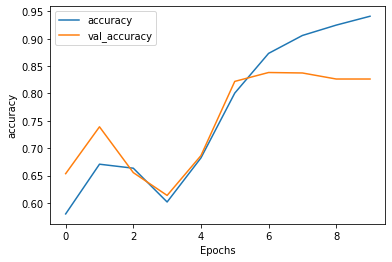

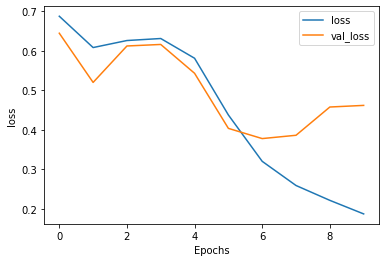

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [12]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 5s 15ms/step - loss: 0.6199 - accuracy: 0.6244 - val_loss: 0.3949 - val_accuracy: 0.8287
Epoch 2/10
196/196 [==============================] - 3s 13ms/step - loss: 0.3401 - accuracy: 0.8557 - val_loss: 0.3665 - val_accuracy: 0.8410
Epoch 3/10
196/196 [==============================] - 3s 13ms/step - loss: 0.2501 - accuracy: 0.9014 - val_loss: 0.3605 - val_accuracy: 0.8472
Epoch 4/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1883 - accuracy: 0.9321 - val_loss: 0.3977 - val_accuracy: 0.8394
Epoch 5/10
196/196 [==============================] - 3s 14ms/step - loss: 0.1397 - accuracy: 0.9528 - val_loss: 0.4849 - val_accuracy: 0.8237
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1087 - accuracy: 0.9642 - val_loss: 0.5393 - val_accuracy: 0.8255
Epoch 7/10
196/196 [==============================] - 3s 13ms/step - loss: 0.0849 - accuracy: 0.9734 - val_loss: 0.6368 - val_accuracy: 0.8230

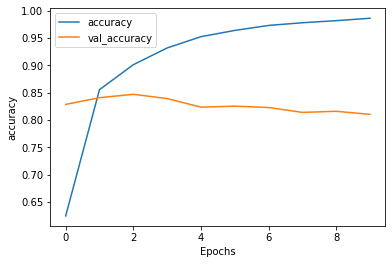

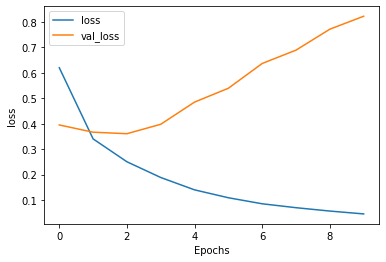

In [14]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [15]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-03-26 07:37:24.192508: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 36/196 [====>.........................] - ETA: 0s - loss: 0.6922 - accuracy: 0.6039

2022-03-26 07:37:24.755674: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 07:37:24.755715: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 07:37:24.784309: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 07:37:24.784335: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

196/196 [==============================] - 3s 8ms/step - loss: 0.5313 - accuracy: 0.7522 - val_loss: 0.3723 - val_accuracy: 0.8352
Epoch 2/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3010 - accuracy: 0.8740 - val_loss: 0.3475 - val_accuracy: 0.8503
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 0.2434 - accuracy: 0.9027 - val_loss: 0.3758 - val_accuracy: 0.8397
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 0.2089 - accuracy: 0.9206 - val_loss: 0.4034 - val_accuracy: 0.8366
Epoch 5/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1831 - accuracy: 0.9324 - val_loss: 0.4432 - val_accuracy: 0.8304
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1624 - accuracy: 0.9417 - val_loss: 0.4881 - val_accuracy: 0.8254
Epoch 7/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1446 - accuracy: 0.9504 - val_loss: 0.5309 - val_accuracy: 0.8190
Epoch 8/10
196/19

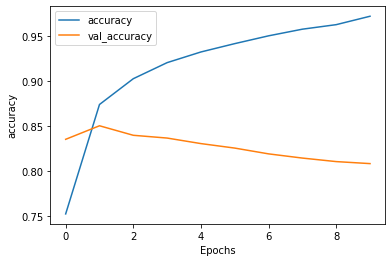

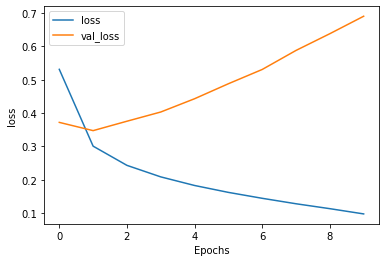

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')